# Fine-Tuning de Vision Transformers para Classificação de Imagens e geração de inputs para LLMs multimodais

Assim como os modelos baseados em transformers revolucionaram o Processamento de Linguagem Natural (NLP), agora estamos vendo uma explosão de artigos aplicando esses modelos a todos os tipos de outros domínios. Um dos mais revolucionários foi o Vision Transformer (ViT), introduzido em [Junho de 2021](https://arxiv.org/abs/2010.11929) por uma equipe de pesquisadores do Google Brain.

Este artigo explorou como é possível tokenizar imagens da mesma forma que se tokenizam frases, permitindo que sejam passadas para modelos transformers durante o treinamento. É um conceito bastante simples, na verdade...

1. Divida uma imagem em uma grade de sub-imagens
2. Incorpore cada sub-imagem com uma projeção linear
3. Cada sub-imagem incorporada se torna um token, e a sequência resultante de sub-imagens incorporadas é a sequência que você passa para o modelo.


Incorpore cada sub-imagem com uma projeção linear
Cada sub-imagem incorporada se torna um token, e a sequência resultante de sub-imagens incorporadas é a sequência que você passa para o modelo.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)


Acontece que, uma vez que você tenha realizado o processo descrito acima, é possível pré-treinar e ajustar transformers da mesma forma como você está acostumado a fazer com tarefas de Processamento de Linguagem Natural (NLP).

---

Além disso, esse enfoque em tokenizar imagens e aplicar modelos transformers também está alinhado com os avanços em Linguagem Natural e Modelos Multimodais (LLMs). Modelos multimodais, como o CLIP (Contrastive Language-Image Pre-training) e o DALL-E, têm sido desenvolvidos para entender e gerar informações a partir de diferentes modalidades, como texto e imagem.

A convergência entre a tokenização de imagens e o desenvolvimento de LLMs multimodais representa uma tendência promissora para abordar problemas complexos que envolvem tanto dados textuais quanto visuais. Essa abordagem integrada oferece a capacidade de compreender e extrair informações significativas de contextos diversificados, impulsionando ainda mais a aplicação de modelos baseados em transformers em uma variedade de domínios.

---


Neste notebook, vamos percorrer o processo de como aproveitar 'hugging_face' datasets para baixar e processar conjuntos de dados de classificação de imagem e, em seguida, utilizá-los para ajustar finamente um ViT pré-treinado com 🤗 transformers. Além disso, exploraremos a etapa de finalização em modelos de Linguagem e Modelos Multimodais (LLMs), onde ajustamos ainda mais o modelo para tarefas específicas relacionadas à linguagem ou à multimodalidade.



In [ ]:
!pip install transformers[torch]

In [ ]:
%%capture

! pip install datasets transformers

## 1. Carregamento de Dados e Visualização

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1034 [00:00<?, ? examples/s]

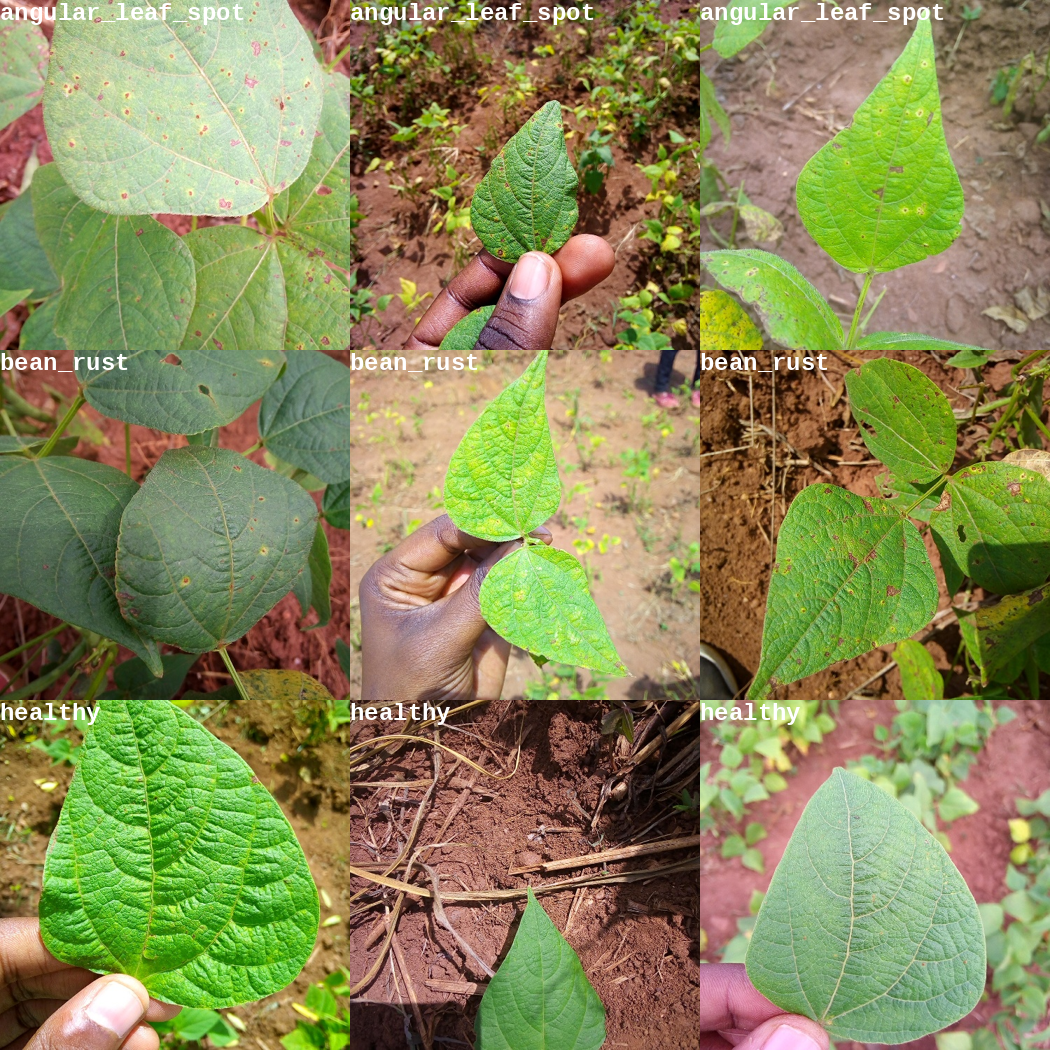

In [ ]:
# Importação de bibliotecas
from datasets import load_dataset
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

# Carrega o conjunto de dados 'beans'
ds = load_dataset('beans')

# Obtém rótulos do conjunto de treinamento
labels = ds['train'].features['labels']

# Função para exibir exemplos de fotos e suas labels
def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## 2. Pré-processamento com ViTFeatureExtractor

In [ ]:
# Importação de bibliotecas
from transformers import ViTFeatureExtractor

image = ds['train'][400]['image']

# Modelo ViT pré-treinado
model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

# Processa um exemplo
feature_extractor(image, return_tensors='pt')

def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## 3. Transformação do Conjunto de Dados

In [ ]:
from datasets import load_dataset

ds = load_dataset('beans')

def transform(example_batch):
    # Torna uma lista de imagens PIL em valores de pixeis
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = ds.with_transform(transform)

## 4. Treinamento do Modelo

In [ ]:
# Importação de bibliotecas
import numpy as np
from datasets import load_metric
from transformers import ViTForImageClassification, TrainingArguments, Trainer
import torch

# Definindo métricas para a avaliação do modelo
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# Configuração do DataLoader
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# Carrega os rótulos
labels = ds['train'].features['labels'].names

# Inicializa um modelo ViT para classificação de imagens
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

# Configuração de argumentos de treinamento
training_args = TrainingArguments(
  output_dir="./vit-base-beans-demo-v5",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

# Configuração do Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor,
)

# Treinamento do modelo
train_results = trainer.train()
trainer.save_model()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy
100,0.069500,0.062919,0.984962
200,0.014800,0.027248,0.992481


## 5. Avaliação do Modelo

In [ ]:
# Avaliação no conjunto de validação
metrics = trainer.evaluate(prepared_ds['validation'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.9925
  eval_loss               =     0.0272
  eval_runtime            = 0:00:05.13
  eval_samples_per_second =     25.917
  eval_steps_per_second   =      3.313


## 6. Extração das features visuais

In [ ]:
from transformers import ViTFeatureExtractor
from PIL import Image

# Carregar modelo ViT pré-treinado para extrair features visuais
vit_model_name = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)

def extract_visual_features(image_path):
    # Carregar e extrair features visuais da imagem usando o modelo ViT
    image = image_path
    inputs = feature_extractor(image, return_tensors="pt")
    return inputs


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


## 7. Geração de features textuais por LLM

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Carregar modelo pré-treinado de linguagem (GPT-2)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2", padding_side='left')
lm_model = GPT2LMHeadModel.from_pretrained("gpt2")

def generate_textual_features(visual_features, attention_mask):
    # Gerar descrição usando GPT-2 com as features visuais, a máscara de atenção e outros parâmetros
    description_ids = lm_model.generate(inputs=visual_features, attention_mask=attention_mask, max_new_tokens=10)
    return description_ids


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

## 8. Geração de Descrições Multimodais

In [ ]:
def generate_description(image_path):
    # Carregar e extrair features visuais da imagem usando o modelo ViT
    image = image_path
    inputs = feature_extractor(image, return_tensors="pt")

    # Remover a chave 'pixel_values' dos inputs
    inputs = {k: v for k, v in inputs.items() if k != 'pixel_values'}

    # Extrair a máscara de atenção da imagem
    attention_mask = feature_extractor(image, return_tensors="pt").get('attention_mask')

    # Definir o ID do token de preenchimento como o ID do token EOS
    pad_token_id = tokenizer.eos_token_id

    # Definir o lado do preenchimento como 'esquerda'
    padding_side = 'left'

    # Gerar descrição usando GPT-2 com as features visuais, a máscara de atenção, o ID do token de preenchimento e o lado do preenchimento
    description_ids = lm_model.generate(**inputs, attention_mask=attention_mask, pad_token_id=pad_token_id, max_new_tokens=10)

    # Converter IDs de descrição de volta para texto
    description = tokenizer.decode(description_ids[0], skip_special_tokens=True)
    return description

# Escolher aleatoriamente um exemplo do conjunto de treinamento
random_index = random.randint(0, len(ds['train']) - 1)
random_image_path = ds['train'][random_index]['image']

# Exemplo de uso
description = generate_description(random_image_path)
print("Generated Description:", description)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Generated Description: 
The first time I saw the new version of
